<a href="https://colab.research.google.com/github/Fassilsis/Sentiment-Analysis-TripAdvisor-Reviews/blob/main/Fassil_Sentiment_Analysis_of_TripAdvisor_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis: TripAdvisor Reviews**
*Fassil Sisay Yehuala*

ReDI School Munich

#Abstract

Many agree that online customer feedback mechanisms are a great way to get an unfiltered view of how customers are rating services. However, research has shown that most online reviews can mislead consumers as consumers' ratings do not significantly correlate with actual quality. In this project, I summarized the overall sentiments and predict ratings using different machine learning techniques on the basis of a TripAdvisor dataset from Kaggle. After the data filtering process, I implemented the rule-based sentiment analysis approach. Then, I implemented TF-IDF. For prediction, I make use of the Random Forest algorithm, owing to its ability to act upon non-normalized data. Finally, in line with other researches, I found out that ratings and sentiments are not highly related. That is, ratings do not reflect customers’ sentiment.

# Table of contents

Table of contents

1 Introduction

2 The Data

3 Text Processing

4 Exploratory Data Analysis

5 Sentiment Analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner)

6 Topic Modeling

7 Prediction

8 Conclusion



#1  Introduction

Online customer feedback mechanisms are a great way to get an unfiltered view of how customers are rating services. However, research has shown that most online reviews can mislead consumers. For example, a study by Bart de Langhe et. al. shows that average consumers' ratings do not significantly correlate with actual quality. That is to say, if we compare a four-star hotel with a three-star hotel, the odds of a four-star hotel to be of high quality are much lower than the expected 100%.

Instead of solely relying on such ratings, some argue that it is better to conduct sentiment analysis of reviews. Such analysis methods utilize natural language texts to get the attitudes, feelings, and emotions of users towards a particular service or product.

The main objectives of this project are to summarize the overall sentiments and predict ratings based on sentiments.

In this project, we will cluster TripAdvisor Reviews into three groups (i.e. Positive, Negative, and Neutral) and compare how they are related to ratings (1 star to 5-star categories).

We will make use of a dataset from Kaggle, Trip Advisor Hotel Reviews - 20k reviews extracted from Tripadvisor (Alam, Ryu, Lee 2016). The dataset has two columns: 'Review' and 'Rating'. 'Review' column contains reviews as given by users. And the 'Rating'column is the number of stars (1 through 5) as assigned by the reviewer: the bigger the number the better.


Let's get started!

#2  The Data

Let's first read the tripadvisor_hotel_reviews.csv file and set it as a dataframe called trip.

In [29]:
#Import basic libraries

import numpy as np
import pandas as pd

#Supress 
import warnings
warnings.filterwarnings("ignore")

In [30]:
#Mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [31]:
trip = pd.read_csv('/content/drive/My Drive/tripadvisor_hotel_reviews.csv')

The first check is to see where values are missing. The information in this file is complete. Luckily, there isn't any data missing in the Review and Rating columns.

In [32]:
#Checking if there are any missing cases
trip.isna().sum()

Review    0
Rating    0
dtype: int64

Check the head, info, and describe methods on trip.

In [33]:
trip.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [34]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Now, let's create a column that contains the number of Characters in the Review column and name it "Characters". We shall also perform the same task for the number of Words in the Review column and call it "Words".

Based on the description statistics shown below, the mean rating is 3.96. More than 2 million words are on the dataset. On average each review contains 106 words and 724 characters.

In [35]:
trip['Characters'] = trip['Review'].apply(lambda i: len(i))
trip["Words"] = trip["Review"].apply(lambda i: len(i.split(' ')))

In [36]:
trip.describe()

,Rating,Characters,Words
count,20491.000000,20491.000000,20491.000000
mean,3.952223,724.896833,106.375043
std,1.233030,689.101024,100.655267
min,1.000000,44.000000,9.000000
25%,3.000000,339.000000,50.000000
50%,4.000000,537.000000,79.000000
75%,5.000000,859.000000,126.000000
max,5.000000,13501.000000,1933.000000


In [37]:
print('Total number of words: {}'.format(trip['Words'].sum()))
print('Total number of Characters: {}'.format(trip['Characters'].sum()))

Total number of words: 2179731
Total number of Characters: 14853861


Average length of review for each rating using groupby function

In [38]:
Ratings = trip.groupby('Rating').mean()
Ratings

,Characters,Words
Rating,,
1,769.534835,114.365236
2,867.002789,128.598438
3,784.664835,116.705586
4,745.339957,109.771154
5,661.696488,95.962889


#3 Text Processing
The most important part of any ML project is data processing. Hence it is crucial to clean the text before doing any further data exploration and putting it into an algorithm. At this stage, I will clean the data and make it ready for further analysis. The text processing involves the following steps:

* Removal of tags
* Removal of punctuation 
* Removal of multiple whitespaces in between texts
* Removal of numerics
* Removal of stop words 
* Removal of very short words
* Stemming: converting words to its roots

In [39]:
# Import text Processing libraries

from gensim import utils
import gensim.parsing.preprocessing as gsp

In [40]:
# Defining function for text cleaning
filters = [gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [41]:
trip.head()

,Review,Rating,Characters,Words
0,nice hotel expensive parking got good deal sta...,4,593,89
1,ok nothing special charge diamond member hilto...,2,1689,252
2,nice rooms not 4* experience hotel monaco seat...,3,1427,219
3,"unique, great stay, wonderful time hotel monac...",5,600,91
4,"great stay great stay, went seahawk game aweso...",5,1281,193


Let's now compare texts befor and after cleaning by applying the function to clean reviews. 

In [42]:
trip.iloc[0,0]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [43]:
clean_text(trip.iloc[0,0])

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night'

Let's apply the function for all of the reviews.

In [44]:
trip['CleanReview'] = trip['Review'].map(lambda x: clean_text(x))
trip.head()

,Review,Rating,Characters,Words,CleanReview
0,nice hotel expensive parking got good deal sta...,4,593,89,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,1689,252,special charge diamond member hilton decided c...
2,nice rooms not 4* experience hotel monaco seat...,3,1427,219,nice rooms experience hotel monaco seattle goo...
3,"unique, great stay, wonderful time hotel monac...",5,600,91,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,1281,193,great stay great stay went seahawk game awesom...


#4  Exploratory Data Analysis

**It is time to explore the data**



In [45]:
# Import the data visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from wordcloud import WordCloud
import PIL.Image

import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from IPython.display import HTML

from collections import Counter
from nltk.probability import FreqDist

In [46]:
#Explore the text content (reviews) using the wordcloud**
def word_cloud (wc):
  wc.generate(' '.join(trip['Review']))
  plt.figure(figsize=(5, 15))
  plt.imshow(wc, interpolation="nearest", aspect="equal")
  plt.tight_layout(pad=0)
  plt.axis('off')
  plt.show()

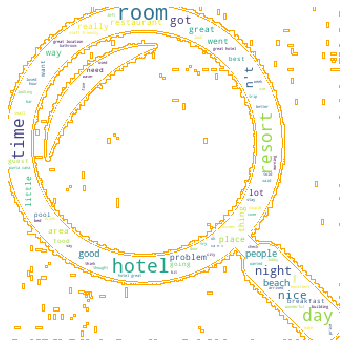

In [47]:

mask = np.array(PIL.Image.open('/content/drive/My Drive/cool5.png'))
wc = WordCloud(background_color='white', mask=mask, width=500, max_words=2000, height=1000, max_font_size = 25,
                 random_state=3, contour_width=0.5, contour_color='orange')

word_cloud (wc)

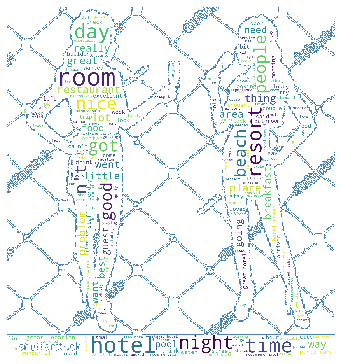

In [48]:
#Explore the text content (reviews) using the wordcloud**
mask = np.array(PIL.Image.open('/content/drive/My Drive/cool3.jpg'))
wc = WordCloud(background_color='white', mask=mask, mode='RGB',
                 width=500, max_words=200, height=1000, min_font_size = 8,
                 random_state=1, contour_width=1, contour_color='steelblue')
word_cloud (wc)

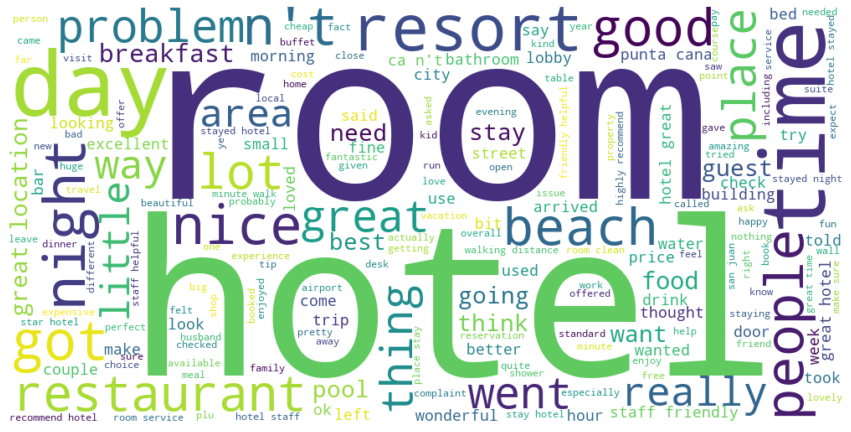

In [49]:
wc = WordCloud(width = 1000, height = 500, background_color ='white', min_font_size = 10, max_words=200).generate(' '.join(trip['Review']))

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

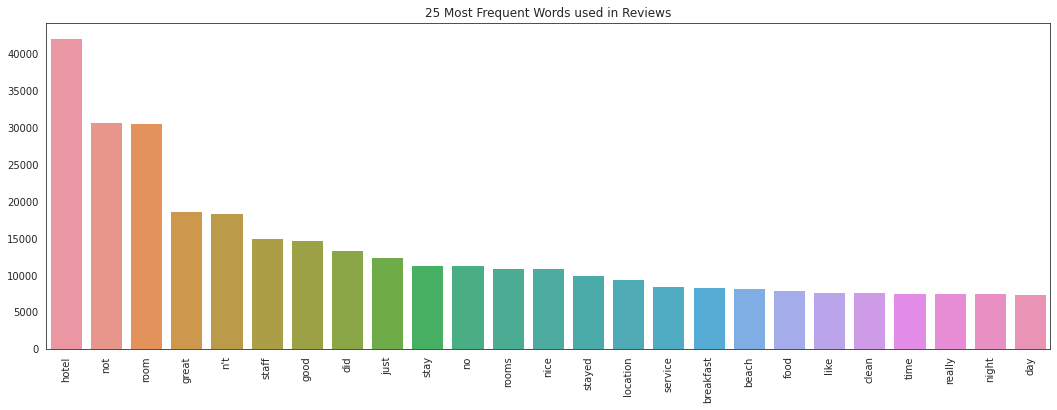

In [50]:
# 25 most frequent words

aggregate_counter = Counter()
for row_index,row in trip.iterrows():
    c = Counter(row['Review'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(25)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(25)]

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

barplot(words=common_words, words_counts=common_words_counts, title='25 Most Frequent Words used in Reviews')

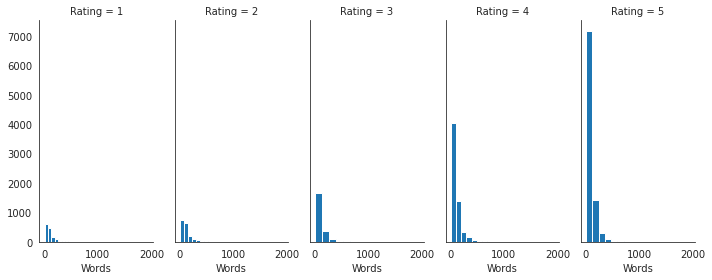

In [51]:
#Let's make a FacetGrid by creating a grid of 5 histograms of review length for each ratings.

g = sns.FacetGrid(trip, col='Rating', height=4, aspect=.5)
g.map(plt.hist, 'Words', bins=15)
plt.show()

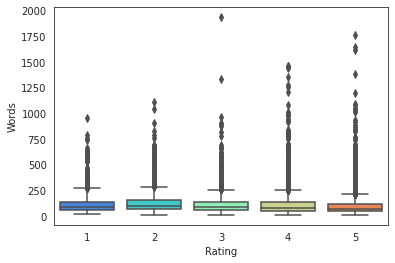

In [52]:
#Create a boxplot of Review Length and Word Count for each Rating category.
sns.boxplot(x='Rating', y='Words',data=trip, palette='rainbow')
plt.show()

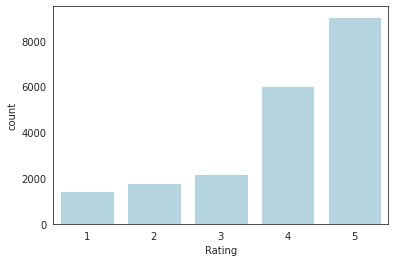

In [53]:
#It is time important to understand the distribution of the ratings. Hence, let's create a countplot of the number of occurrences for each type of rating.
sns.countplot(x='Rating',data=trip, color='lightblue')
plt.show()

In [54]:
Ratings

,Characters,Words
Rating,,
1,769.534835,114.365236
2,867.002789,128.598438
3,784.664835,116.705586
4,745.339957,109.771154
5,661.696488,95.962889


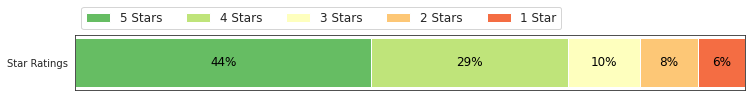

In [55]:
X = trip.Rating.value_counts()
X = pd.DataFrame(X)
X = (X['Rating']/X['Rating'].sum())*100


category_names = ['5 Stars', '4 Stars', '3 Stars', '2 Stars', '1 Star']
results = {'Star Ratings': X}


def graph (results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.8, 0.2, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12, 1))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.8, label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'black'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(str(int(c))+'%'), ha='center', va='center',
                    color=text_color, fontsize='large',)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


graph(results, category_names)
plt.show()

# 5 Sentiment Analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner) 

One of the tools that I employed is VADER, a lexicon and rule-based sentiment analysis tool which uses a list of lexical features that are labelled according to semantic orientations.  For each text content, VADER returns 4 scores: a neutrality score, a positivity score, a negativity score, and a compound score that summarizes the previous scores. Each scores ranges from -1 to +1. 

Based on this score into 3 categories: negative, positive and neutral. The review is positive if the compound score is greater than 0.2 and negative if the compound score is less than 0.2.  For those in between, the review is assigned as neural.

Based on the analysis, it is safe to say that most of the hotels on TripAdvisor have positive reviews. To be exact, 91.2% of the reviews are positive and only 8.80% of the reviews are negative.

In [56]:
#Import libraries for Vader
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Import libraries for Tfidf Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [57]:
sia = SentimentIntensityAnalyzer()
trip["Sentiments"] = trip["Review"].apply(lambda i: sia.polarity_scores(i))
trip = pd.concat([trip.drop(['Sentiments'], axis=1), trip['Sentiments'].apply(pd.Series)], axis=1)

In [58]:
trip['Sentiment'] = ''
for i in range(0, len(trip)): 
   if (trip.loc[i,'compound']  > 0.2):
    trip.loc[i,'Sentiment'] = 'Positive' 
   elif (trip.loc[i,'compound']  < -0.2):
    trip.loc[i,'Sentiment'] = 'Negative'   
   else:
     trip.loc[i,'Sentiment'] = 'Neutral'

In [59]:
trip.tail()

,Review,Rating,Characters,Words,CleanReview,neg,neu,pos,compound,Sentiment
20486,"best kept secret 3rd time staying charm, not 5...",5,733,111,best kept secret time staying charm star beat ...,0.063,0.665,0.272,0.9834,Positive
20487,great location price view hotel great quick pl...,4,306,41,great location price view hotel great quick pl...,0.000,0.570,0.430,0.9753,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,443,65,looks nice modern outside desk staff particula...,0.131,0.724,0.145,0.2629,Positive
20489,hotel theft ruined vacation hotel opened sept ...,1,5557,783,hotel theft ruined vacation hotel opened sept ...,0.150,0.671,0.179,0.9867,Positive
20490,"people talking, ca n't believe excellent ratin...",2,620,92,people talking believe excellent ratings hotel...,0.193,0.668,0.140,-0.6071,Negative


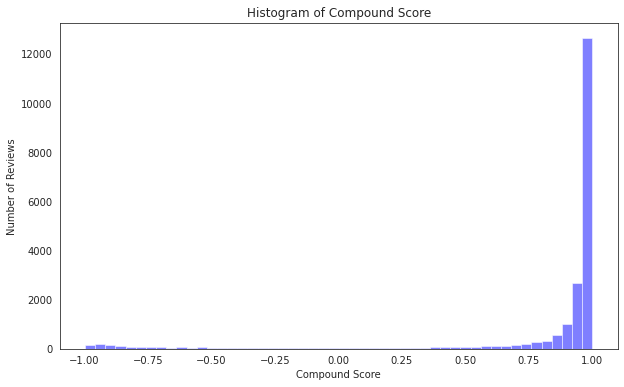

In [60]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(trip.compound, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Compound Score')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Compound Score')
plt.show()

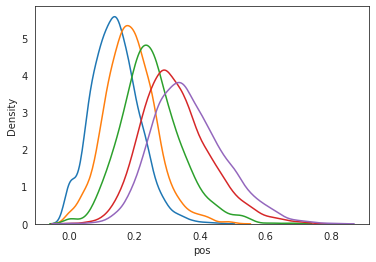

In [61]:
for i in [1, 2, 3, 4, 5]:
    subset = trip[trip['Rating'] == i]
    
    # Draw the density plot
    if i == 1:
        label = "Very Bad Rating"
    elif i == 2:
        label = "Bad reviews"
    elif i == 3:
        label = "Moderate reviews"
    elif i == 4:
        label = "Good Reviews"
    else:
        label = "Very Good Reviews"
    sns.distplot(subset['pos'], hist = False, label = label)
plt.show()

Let's check polarity, a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

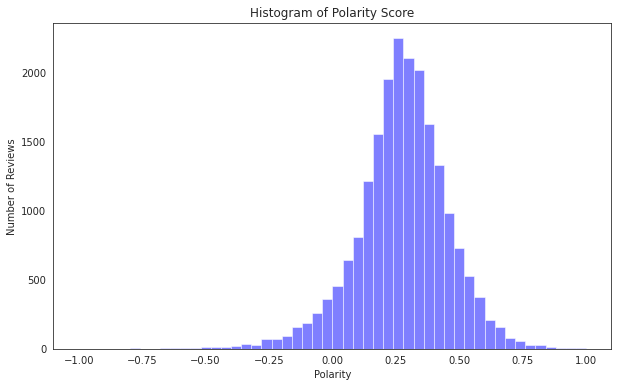

In [62]:
from textblob import TextBlob
trip['Review']= trip['Review'].astype(str) 
pol = lambda x: TextBlob(x).sentiment.polarity
trip['Polarity'] = trip['Review'].apply(pol) 
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(trip.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show()

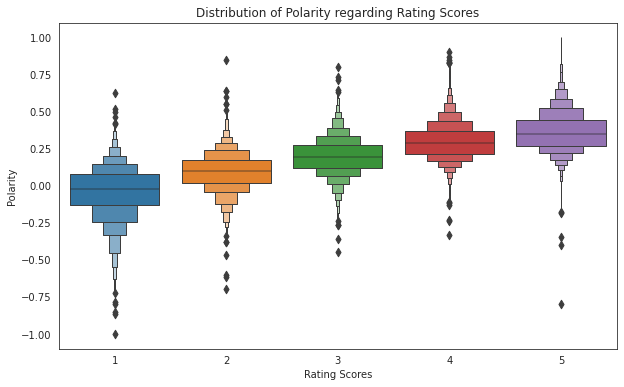

In [63]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='Rating', y='Polarity', data=trip)
plt.xlabel('Rating Scores')
plt.ylabel('Polarity')
plt.title('Distribution of Polarity regarding Rating Scores')
plt.show()

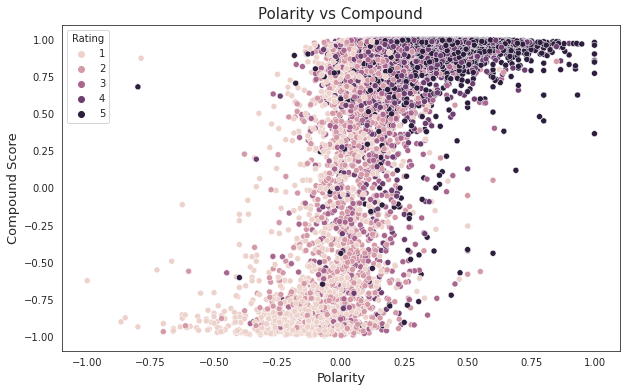

In [64]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Polarity', y='compound', hue='Rating', data=trip)
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Compound Score', fontsize=13)
plt.title('Polarity vs Compound', fontsize=15)
plt.show()

Positive    91.196135
Negative     7.027475
Neutral      1.776390
Name: Sentiment, dtype: float64


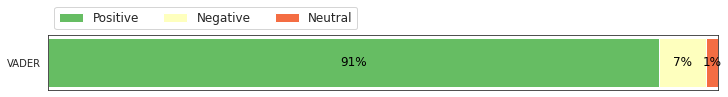

In [91]:
Sentiment_count = trip.Sentiment.value_counts()
Sentiment_count = pd.DataFrame(Sentiment_count)
Sentiment_count = (Sentiment_count['Sentiment']/Sentiment_count['Sentiment'].sum())*100
print(Sentiment_count)

category_names = ['Positive', 'Negative', 'Neutral']
results = {'VADER': Sentiment_count}

graph(results, category_names)
plt.show()

In [78]:
positive_reviews =trip[(trip.Sentiment == 'Positive')].CleanReview
negative_reviews = trip[(trip.Sentiment == 'Negative')].CleanReview

In [79]:
print(positive_reviews.head(1).tolist())

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night']


In [89]:
print(negative_reviews.sample(1).tolist())

['filthy hotel rotten service hotel filthy infested large brown cockaroachesthe staff rud charge dls day parking hotels old smells bad plumbing bad stayed week room claned beds changed ask shampoo soap towels horrible experience family consider stay hotel know hotels com expedia esponsor filthy hotel hotels com advertises know hotels wich false way stayed room stay room filthy thank nick carreno']


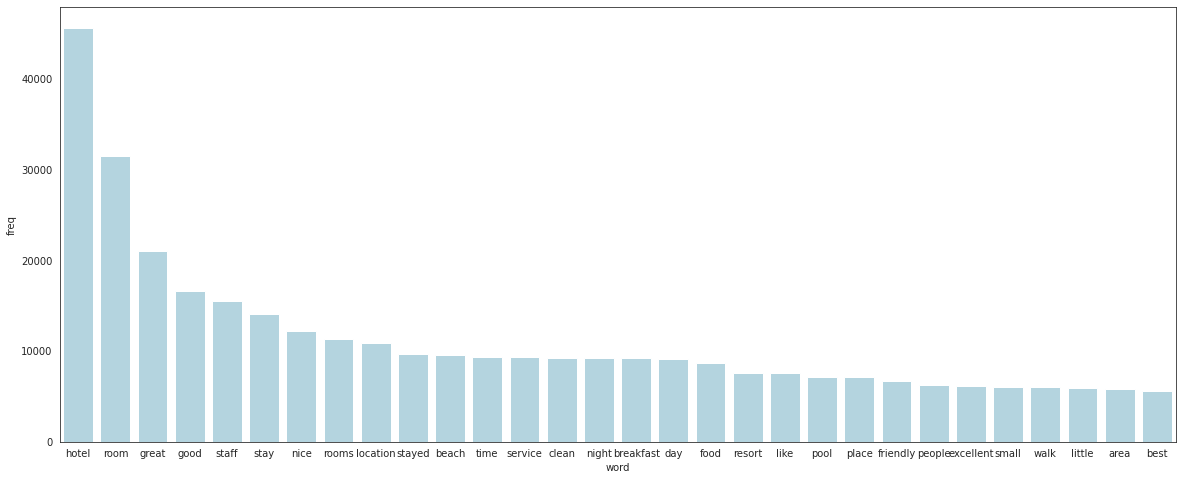

In [93]:
import collections

cv = CountVectorizer()
bow = cv.fit_transform(positive_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x="word", y="freq", data=word_counter_df, color="lightblue", ax=ax)
plt.show();

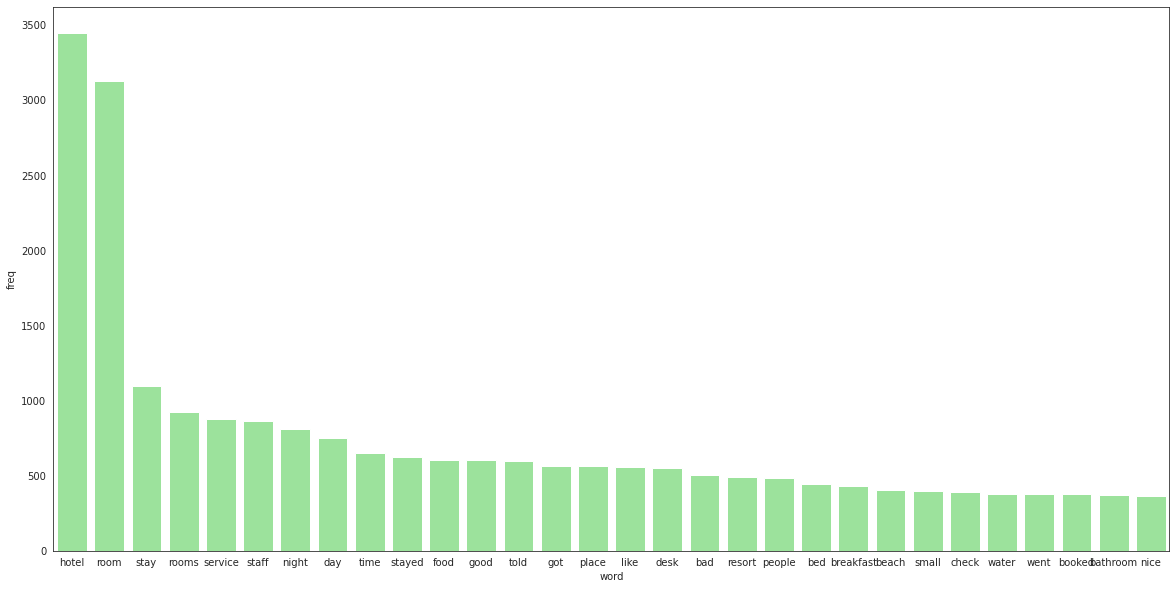

In [96]:
cv = CountVectorizer()
bow = cv.fit_transform(negative_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, color="lightgreen", ax=ax)
plt.show();

#6 Topic Modeling

In [ ]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(trip['CleanReview'])


# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 3
number_words = 15
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Top 3 Topics:")
print_topics(lda, count_vectorizer, number_words)

Top 3 Topics:

Topic #0:
room hotel stay night staff rooms good nice desk service bed day breakfast stayed time

Topic #1:
beach resort food great good pool room time day people nice like staff service water

Topic #2:
hotel great room location staff stay good stayed rooms breakfast clean nice excellent friendly helpful


#7 Prediction

In the previous section, I converted the data into the numeric form. I will make use of the Random Forest algorithm, owing to its ability to act upon non-normalized data.


In [98]:
#Import libraries for prediction

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score 


In [100]:
columns =  ['compound', 'neg',	'neu',	'pos', 'Polarity', 'Words']

train_X, test_X, train_y, test_y = train_test_split(trip[columns], trip['Rating'])
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)
rfc_predictions= rfc.predict(test_X)
rfc_predictions = np.round(rfc_predictions)
print(classification_report(rfc_predictions,test_y))


              precision    recall  f1-score   support

           1       0.56      0.54      0.55       367
           2       0.35      0.34      0.35       447
           3       0.14      0.28      0.19       288
           4       0.36      0.37      0.36      1388
           5       0.71      0.62      0.67      2633

    accuracy                           0.51      5123
   macro avg       0.42      0.43      0.42      5123
weighted avg       0.54      0.51      0.52      5123



#8  Conclusion

This study:

* aims at improving the service operations

* identifies customer sentiments

* summarizes the customer’s reviews using different techniques

* shows ratings and sentiments are not highly related

* Ratings  do not reflect customers’ sentiment


